In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

treino = treino.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])

In [6]:
numeric_feats = treino.dtypes[treino.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')
numeric_feats = numeric_feats.drop('situacao')

treino[numeric_feats] = np.log1p(treino[numeric_feats])

teste[numeric_feats] = np.log1p(teste[numeric_feats])

In [7]:
treino_X = treino.loc[:,:'ocupacao']
treino_Y = treino.loc[:,'situacao']

In [8]:
treino_X = pd.get_dummies(treino_X)

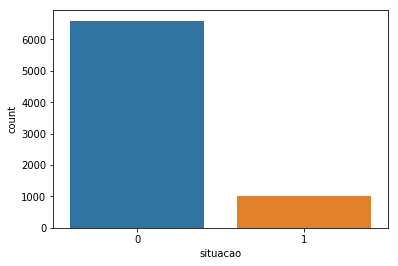

In [9]:
sns.countplot(treino_Y)

É clara a diferença entre a quantidade de instâncias da classe nao_eleito e eleito. Isso pode levar o modelo a aprender de forma errada a classificar os exemplos de teste.

Para balancear as classes usarei a técnica de under-sampling, cluser centroids.

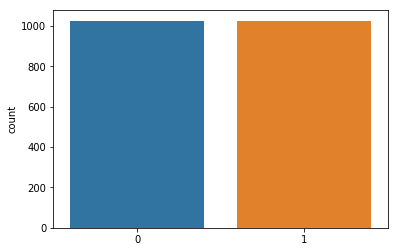

In [10]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
x_cc, y_cc = cc.fit_sample(treino_X, treino_Y)

sns.countplot(y_cc)

Com a mesma quantidade de instâncias entre as duas classes, a chance de o modelo sofrer de unerfiting é bem menor.

A seguir inicio o treinamento de alguns modelos a partir dos dados filtrados.

## Regressão Logística

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics

def cv_train(model, predictors, outcome, nfolds):
    
    kf = KFold(x_cc.shape[0], n_splits=nfolds)
    error = []
    precisions = []
    recalls = []
    f1 = []
    for train, validation in kf:
        train_predictors = (predictors.iloc[train,:])
        train_target =  outcome.iloc[train]
        model.fit(train_predictors, train_target)
        
        report = metrics.classification_report(outcome.iloc[validation], model.predict(predictors.iloc[validation,:]), output_dict=True)
        error.append(report)
    
    return error

In [24]:
from sklearn.linear_model import LogisticRegression

lambdas = np.arange(0.1,1,0.1).tolist()
cv_logRegression = cv_train(LogisticRegression(random_state=1, solver="lbfgs", max_iter=10000),x_cc,y_cc,5)

TypeError: __init__() got multiple values for argument 'n_splits'

In [14]:
lgReg = LogisticRegression(random_state=1, solver="lbfgs", max_iter=10000)
lgReg.fit(x_cc,y_cc)
print(lgReg.predict(treino_X))


[0 0 1 ... 0 0 0]


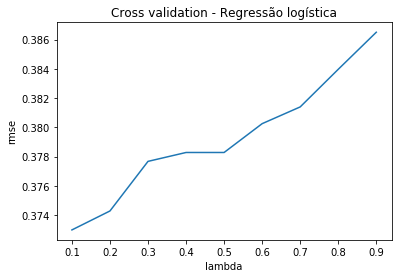

In [11]:
cv_logRegression.plot(title = "Cross validation - Regressão logística")
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.show()